# Банки — Анализ оттока клиентов

**Цель исследования**: 

Выделить портрет клиентов, которые склонны уходить из банка. СФормулировать рекмендации по удержанию клиетов банка (снизить отток клиетов).

### Шаг 1. Загрузка и чтение файла с данными

Импортируем библиотеки, прочитаем файл.

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
import datetime as dt
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
import re
from io import BytesIO
import requests
from plotly import graph_objects as go
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import statistics 

In [2]:
#Чтение файла с данными и сохранение его в переменную
path = "https://drive.google.com/uc?export=download&id=1zBY_MIHwC9SKr7QO1ObJpp6pnCfpXuJv"
df = pd.read_csv(path)
df.head(5)

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn
0,258835,838.0,Ростов,Ж,32,1,377652.29,2,0,1,105665.06,1
1,96660,845.0,Ростов,Ж,31,3,214980.98,5,0,1,62058.62,0
2,99838,869.0,Ростов,Ж,30,4,467040.46,2,1,1,156945.23,1
3,216099,856.0,Рыбинск,Ж,25,4,475727.88,4,0,1,19502.68,0
4,120240,873.0,Рыбинск,Ж,37,3,1350858.40,4,0,1,119804.41,0


In [3]:
#Общая информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            10000 non-null  int64  
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  salary         10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB


Необходимо провести предобработку, подготовить данные к анализу: изучить пропущенные значения (столбец balance), проверить типы данных, проверить данные на наличие дубликатов, аномалий, применить кодирование для категориальных данных.

### Шаг 2. Предобработка данных

#### 2.1 Проверка на дубликаты

In [4]:
#Проверка на дубликаты
df.duplicated().sum()

0

В датасете нет дубликатов.

#### 2.2 Кодирование

Для проведения анализа необходимо заменить значения в столбцах gender и city. В этих столбцах представлены  категориальные неупорядочные данные. Поэтому, применим  one-hot кодирование в этих столбцах  при помощи pandas.get_dummies.

In [5]:
#Проверка значений в столбцах на уникальность
display(df['city'].unique())
display(df['gender'].unique())

array(['Ростов', 'Рыбинск', 'Ярославль'], dtype=object)

array(['Ж', 'М'], dtype=object)

In [6]:
#Кодирование
df = pd.get_dummies(df, columns=['city', 'gender'])
df

,userid,score,age,equity,balance,products,credit_card,last_activity,salary,churn,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,258835,838.0,32,1,377652.29,2,0,1,105665.06,1,1,0,0,1,0
1,96660,845.0,31,3,214980.98,5,0,1,62058.62,0,1,0,0,1,0
2,99838,869.0,30,4,467040.46,2,1,1,156945.23,1,1,0,0,1,0
3,216099,856.0,25,4,475727.88,4,0,1,19502.68,0,0,1,0,1,0
4,120240,873.0,37,3,1350858.40,4,0,1,119804.41,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,186605,693.0,42,0,NaN,2,1,1,221661.10,0,0,1,0,0,1
9996,204842,655.0,27,0,NaN,1,1,0,144948.73,0,0,0,1,0,1
9997,216640,828.0,44,2,168323.87,2,1,1,163995.10,0,0,0,1,1,0
9998,168786,883.0,38,3,342099.90,2,1,0,80587.26,0,0,1,0,1,0


In [7]:
#Переименование столбцов
df = df.rename(columns={'city_Ростов': 'city_rostov', 'city_Рыбинск': 'city_rybinsk','city_Ярославль': 'city_yaroslavl', 'gender_Ж': 'female', 'gender_М': 'male'})
df

,userid,score,age,equity,balance,products,credit_card,last_activity,salary,churn,city_rostov,city_rybinsk,city_yaroslavl,female,male
0,258835,838.0,32,1,377652.29,2,0,1,105665.06,1,1,0,0,1,0
1,96660,845.0,31,3,214980.98,5,0,1,62058.62,0,1,0,0,1,0
2,99838,869.0,30,4,467040.46,2,1,1,156945.23,1,1,0,0,1,0
3,216099,856.0,25,4,475727.88,4,0,1,19502.68,0,0,1,0,1,0
4,120240,873.0,37,3,1350858.40,4,0,1,119804.41,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,186605,693.0,42,0,NaN,2,1,1,221661.10,0,0,1,0,0,1
9996,204842,655.0,27,0,NaN,1,1,0,144948.73,0,0,0,1,0,1
9997,216640,828.0,44,2,168323.87,2,1,1,163995.10,0,0,0,1,1,0
9998,168786,883.0,38,3,342099.90,2,1,0,80587.26,0,0,1,0,1,0


#### 2.3 Пропущенные значения 

In [8]:
#Выведем пропуски по датасету
df.isna().sum()

userid               0
score                0
age                  0
equity               0
balance           2295
products             0
credit_card          0
last_activity        0
salary               0
churn                0
city_rostov          0
city_rybinsk         0
city_yaroslavl       0
female               0
male                 0
dtype: int64

Видно, что пропуски есть только в столбце balance (23%). Для того чтобы корректно определить, как заполнить эти пропуски, изучим как пропуски связаны с остальными данными в датасете.

In [9]:
#Выделим данные клиентов с пропущенными значениями в столбце balance в отдельный датасет
empty_balance = df[df['balance'].isna()]
empty_balance.head(5)

,userid,score,age,equity,balance,products,credit_card,last_activity,salary,churn,city_rostov,city_rybinsk,city_yaroslavl,female,male
408,261907,734.0,79,3,NaN,0,0,0,25063.96,1,0,1,0,1,0
1439,154581,662.0,32,0,NaN,1,1,0,82847.95,0,0,1,0,0,1
1442,92746,687.0,31,0,NaN,1,1,1,133324.89,0,0,1,0,0,1
1443,161908,664.0,29,0,NaN,1,1,0,120174.24,0,0,0,1,1,0
1453,155767,703.0,33,0,NaN,1,1,0,171038.71,0,0,0,1,1,0


In [10]:
#Список, датасет для бинарных переменных
list1=['city_rostov','city_rybinsk', 'city_yaroslavl', 'female','male', 'credit_card', 'last_activity', 'churn']
empty_balance1 = empty_balance[['city_rostov','city_rybinsk', 'city_yaroslavl', 'female','male', 'credit_card', 'last_activity', 'churn']]
#Список, датасет для количественных пременных
list2=['userid','score', 'age', 'equity','balance', 'products', 'salary']
empty_balance2 = empty_balance[['userid', 'score', 'age', 'equity','balance', 'products', 'salary']]

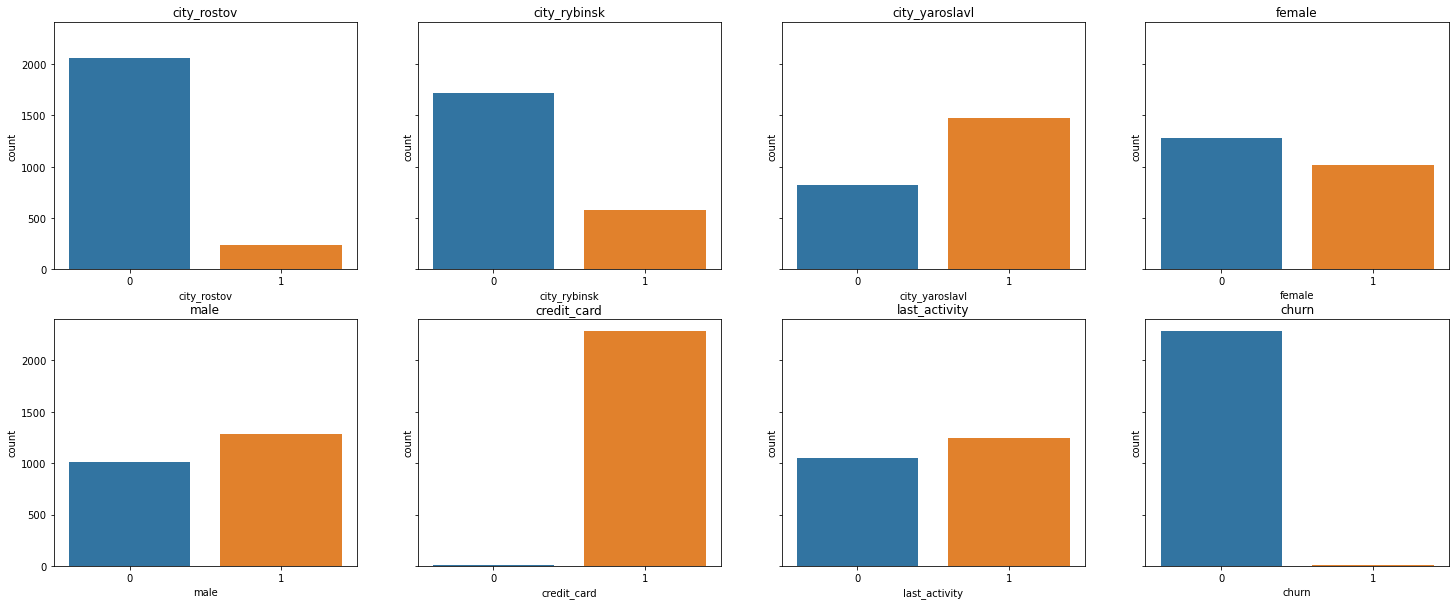

In [11]:
#Посмотрим на категоральные(бинарные) признаки в датасете с пропусками 
fig, axis = plt.subplots(2, 4,figsize=[25,10], sharey=True)
axis = axis.flatten()
                                                                                          
for num, col in enumerate(empty_balance1):  
    sns.countplot(data = empty_balance1, x = col, ax = axis[num])    
    axis[num].set_title(f'{col}')   

Больше всего клиентов банка с неуказанным балансом из Ярославля, меньше всего из Ростова. Также видно, что больше половины пользователей с неуказанным балансом были активны в последнее время. Почти у всех пользователей есть кредитная карта и почти никто не планируеть уходить.

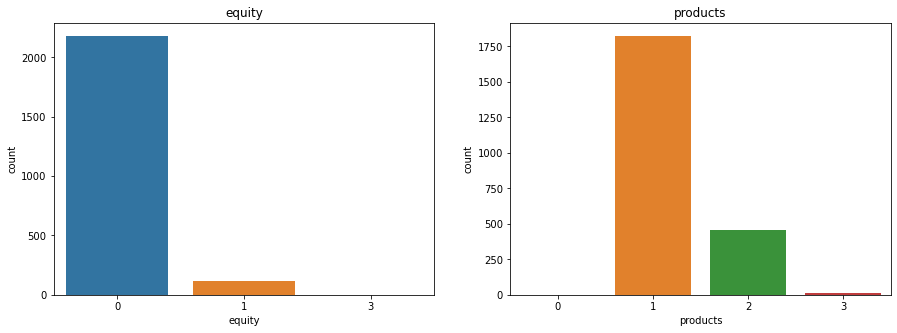

In [12]:
#Посмотрим на количественные признаки в датасете с пропусками (столбцы 'equity', 'products')
empty_balance3 = empty_balance2[['equity', 'products']]

fig, axis = plt.subplots(1, 2,figsize=[15,5])
axis = axis.flatten()
                                                                                          
for num, col in enumerate(empty_balance3):  
    sns.countplot(data = empty_balance3, x = col, ax = axis[num])    
    axis[num].set_title(f'{col}')  

Из графиков видно, что у большинства клиентов с пропущенным балансом приблизительная оценка собственности равна 0. Также, большинство клиентов с пропущенным балансом пользуются 1 банковским продуктом.

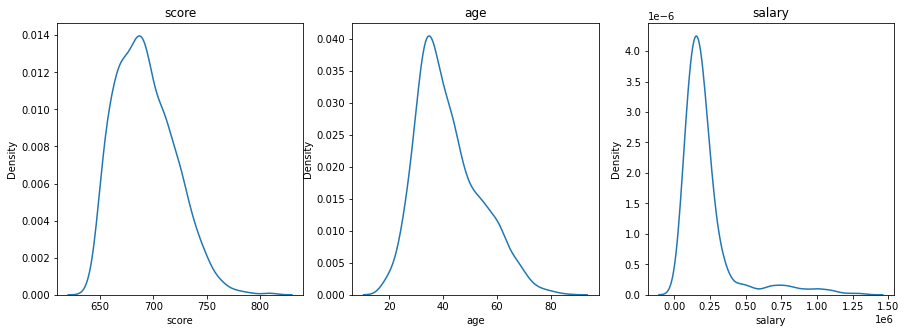

In [13]:
#Посмотрим на распределение количественных признаки в датасете с пропусками (столбцы 'score', 'age','salary')
empty_balance4 = empty_balance2[['score', 'age','salary']]

fig, axis = plt.subplots(1, 3,figsize=[15,5])
axis = axis.flatten()
                                                                                          
for num, col in enumerate(empty_balance4):  
    sns.kdeplot(data = empty_balance4, x = col, ax = axis[num])    
    axis[num].set_title(f'{col}') 

Исходя из анализа категориальных и количественных признаков в датасете с пропущенными значениями, можно предположить, что пропуски связаны с наличием кредитных продуктов(является отличительным признаком - у всех клиентов с неуказанным балансом есть кредитная карта). Т.е. клиенты только брали кредит в банке, но не имели расчетного счета для хранения денежных средств (дебитовой карты). Таким образом, предлагается оставить пропуски без изменений (на ноль значения менять нельзя, так как в датасете есть клиенты с нулевым балансом - есть расчетный счет, но не пополнен).

#### 2.4 Проверка на аномалии/выбросы.

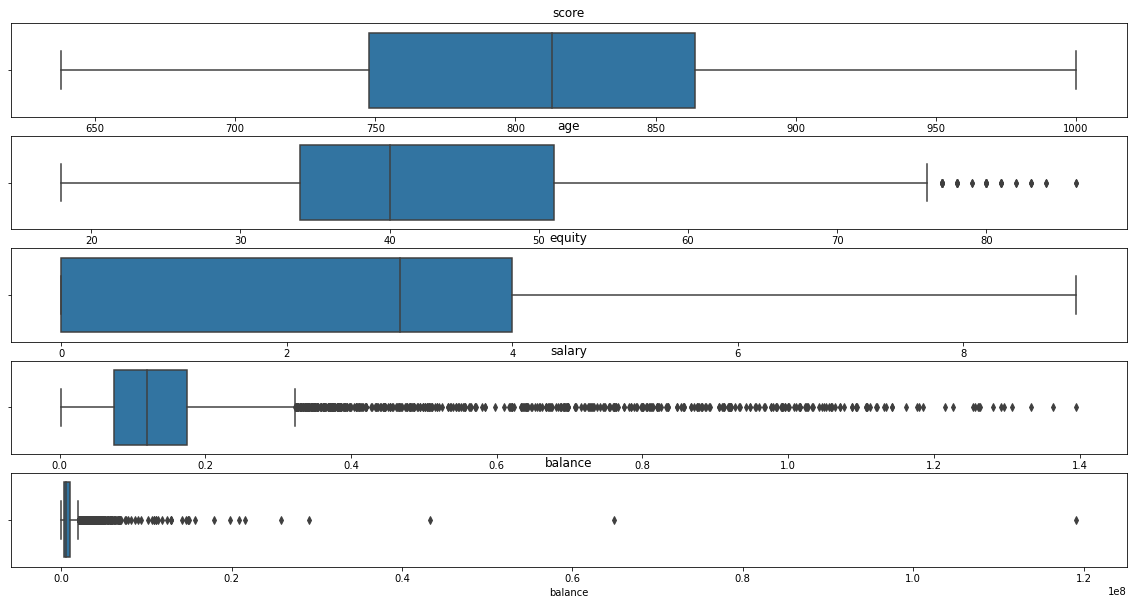

In [14]:
#Проверим наличие выбросов в числовых признаках
df2 = df[['score', 'age', 'equity', 'salary', 'balance']]

fig, axis = plt.subplots(5, 1,figsize=[20,10])
axis = axis.flatten()
                                                                                          
for num, col in enumerate(df2):  
    sns.boxplot(data = df2, x = col, ax = axis[num])    
    axis[num].set_title(f'{col}')

Видно, что выбросы есть в столбцах age, salary и balance по верхней границе. Изучим более подробно эти признаки.

In [15]:
#Минимальное и макимальное значение в столбцах
min_age = df['age'].min()
print(f"Минимальное значение в столбце age - {min_age} лет")
max_age = df['age'].max()
print(f"Максимальное значение в столбце age - {max_age} лет")
min_salary = df['salary'].min()
print(f"Минимальное значение в столбце salary - {min_salary} руб")
max_salary = df['salary'].max()
print(f"Максимальное значение в столбце salary - {max_salary} руб")
min_balance = df['balance'].min()
print(f"Минимальное значение в столбце balance - {min_balance} руб")
max_balance = df['balance'].max()
print(f"Максимальное значение в столбце balance - {max_balance} руб")

Минимальное значение в столбце age - 18 лет
Максимальное значение в столбце age - 86 лет
Минимальное значение в столбце salary - 2546.3 руб
Максимальное значение в столбце salary - 1395064.45 руб
Минимальное значение в столбце balance - 0.0 руб
Максимальное значение в столбце balance - 119113552.01 руб


In [16]:
#Используем межквартильный метод для определения верхней границы выбросов для столбца age
for x in ['age']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
    max = q75+(1.5*intr_qr)
    print(max)    

76.5


In [17]:
#Используем межквартильный метод для определения верхней границы выбросов для столбца salary
for x in ['salary']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
    max = q75+(1.5*intr_qr)
    print(max)    

323373.50625


In [18]:
#Используем межквартильный метод для определения верхней границы выбросов для столбца balance
df3 = df2[df2['balance'].notna()]
for x in ['balance']:
    q75,q25 = np.percentile(df3.loc[:,x],[75,25])
    intr_qr = q75-q25
    max = q75+(1.5*intr_qr)
    print(max) 

2007906.865


In [19]:
#Получим таблицу для дальнейшего исследования
final_df = df.loc[(df['age'] < 76.5) & (df['salary'] < 323373.50625) & (df['balance'] < 2007906.865)]
final_df

,userid,score,age,equity,balance,products,credit_card,last_activity,salary,churn,city_rostov,city_rybinsk,city_yaroslavl,female,male
0,258835,838.0,32,1,377652.29,2,0,1,105665.06,1,1,0,0,1,0
1,96660,845.0,31,3,214980.98,5,0,1,62058.62,0,1,0,0,1,0
2,99838,869.0,30,4,467040.46,2,1,1,156945.23,1,1,0,0,1,0
3,216099,856.0,25,4,475727.88,4,0,1,19502.68,0,0,1,0,1,0
4,120240,873.0,37,3,1350858.40,4,0,1,119804.41,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,66600,823.0,26,5,278208.83,3,1,1,25945.14,0,1,0,0,0,1
9990,134595,790.0,27,3,98552.97,2,1,0,26608.58,0,0,1,0,0,1
9992,101426,843.0,41,2,334070.63,2,0,0,152322.57,0,1,0,0,1,0
9997,216640,828.0,44,2,168323.87,2,1,1,163995.10,0,0,0,1,1,0


Осталось 7184 строк (было 10000, удалено 2816 строк или 28,2%).

Типы данных в датасете изменять не требуется. Данные подготовлены для анализа.

### Шаг 3. Исследовательский анализ данных

#### 3.1 Изучим значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

Для количественных признаков посмотрим средние значения.

In [20]:
#Средние значения для количественных признаков

#Датасет для определения средних значений количественных признаков
final_df1 = final_df[['score', 'age', 'equity','balance', 'products', 'salary', 'churn']]

final_df1_pivot = final_df1.pivot_table(index='churn', aggfunc='mean').T.apply(lambda s: s.apply('{0:.2f}'.format))
final_df1_pivot.columns = ['stay', 'leave']
final_df1_pivot

,stay,leave
age,43.54,39.01
balance,568775.37,857260.52
equity,3.23,3.94
products,2.13,2.48
salary,106065.12,129176.61
score,825.94,868.36


Средний возраст клиентов, которые собираются уходить, немного ниже чем у тех кто остается (39 и 43 года соответственно). У уходящих выше баланс,ЗП, баллы кредитного скоринга, оценка собственности.

Изучим бинарные признаки.

In [21]:
#Формирование датасета
final_df2 = final_df[['city_rostov','city_rybinsk', 'city_yaroslavl', 'female','male', 'credit_card', 'last_activity', 'churn']]

In [22]:
final_df2_churn = final_df2.groupby('churn').agg('sum').T
final_df2_churn.columns = ['stay', 'leave']
final_df2_churn['sum'] = final_df2_churn['stay'] + final_df2_churn['leave']
final_df2_churn['leave_ratio, %'] = round(final_df2_churn['leave'] / final_df2_churn['sum'] *100, 2)
final_df2_churn['stay_ratio, %'] = round(final_df2_churn['stay'] / final_df2_churn['sum'] *100, 2)
final_df2_churn

,stay,leave,sum,"leave_ratio, %","stay_ratio, %"
city_rostov,985.0,164.0,1149.0,14.27,85.73
city_rybinsk,1739.0,241.0,1980.0,12.17,87.83
city_yaroslavl,3377.0,678.0,4055.0,16.72,83.28
female,3301.0,468.0,3769.0,12.42,87.58
male,2800.0,615.0,3415.0,18.01,81.99
credit_card,5180.0,650.0,5830.0,11.15,88.85
last_activity,2608.0,879.0,3487.0,25.21,74.79


In [23]:
#Количество остающихся и уходящих
print('Количество уходящих - {}, остающихся в банке - {}'.format(
        len(final_df[final_df['churn'] == 1]),
        len(final_df[final_df['churn'] == 0])))

Количество уходящих - 1083, остающихся в банке - 6101


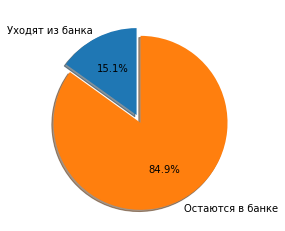

In [24]:
#Диаграмма для презентации
labels = 'Уходят из банка', 'Остаются в банке'
result = [1083, 6101]
explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie(result, explode=explode, labels=labels, shadow=True, startangle=90, autopct='%1.1f%%')
plt.show()

Итак, из 1083 уходящих из банка, основную часть составляют клиенты из Ярославля (678 человек или 62%). Относительный показатель оттока также самый высокий в Ярославле (почти 17% от общего числа клиентов в этом городе).Самый низкий показатель оттока в Рыбинске (12%).

Основную часть уходящих сотавляют мужчины (615 человек или  57%). Относительный показатель оттока у мужчин 18%, против 12,4% у женщин.

Кредитные карты  есть у 650 человек из числа уходящих (60%). 

Были активны в последнее время 879 клиентов из числа уходящих (81%).

#### 3.2 Построим столбчатые гистограммы  распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

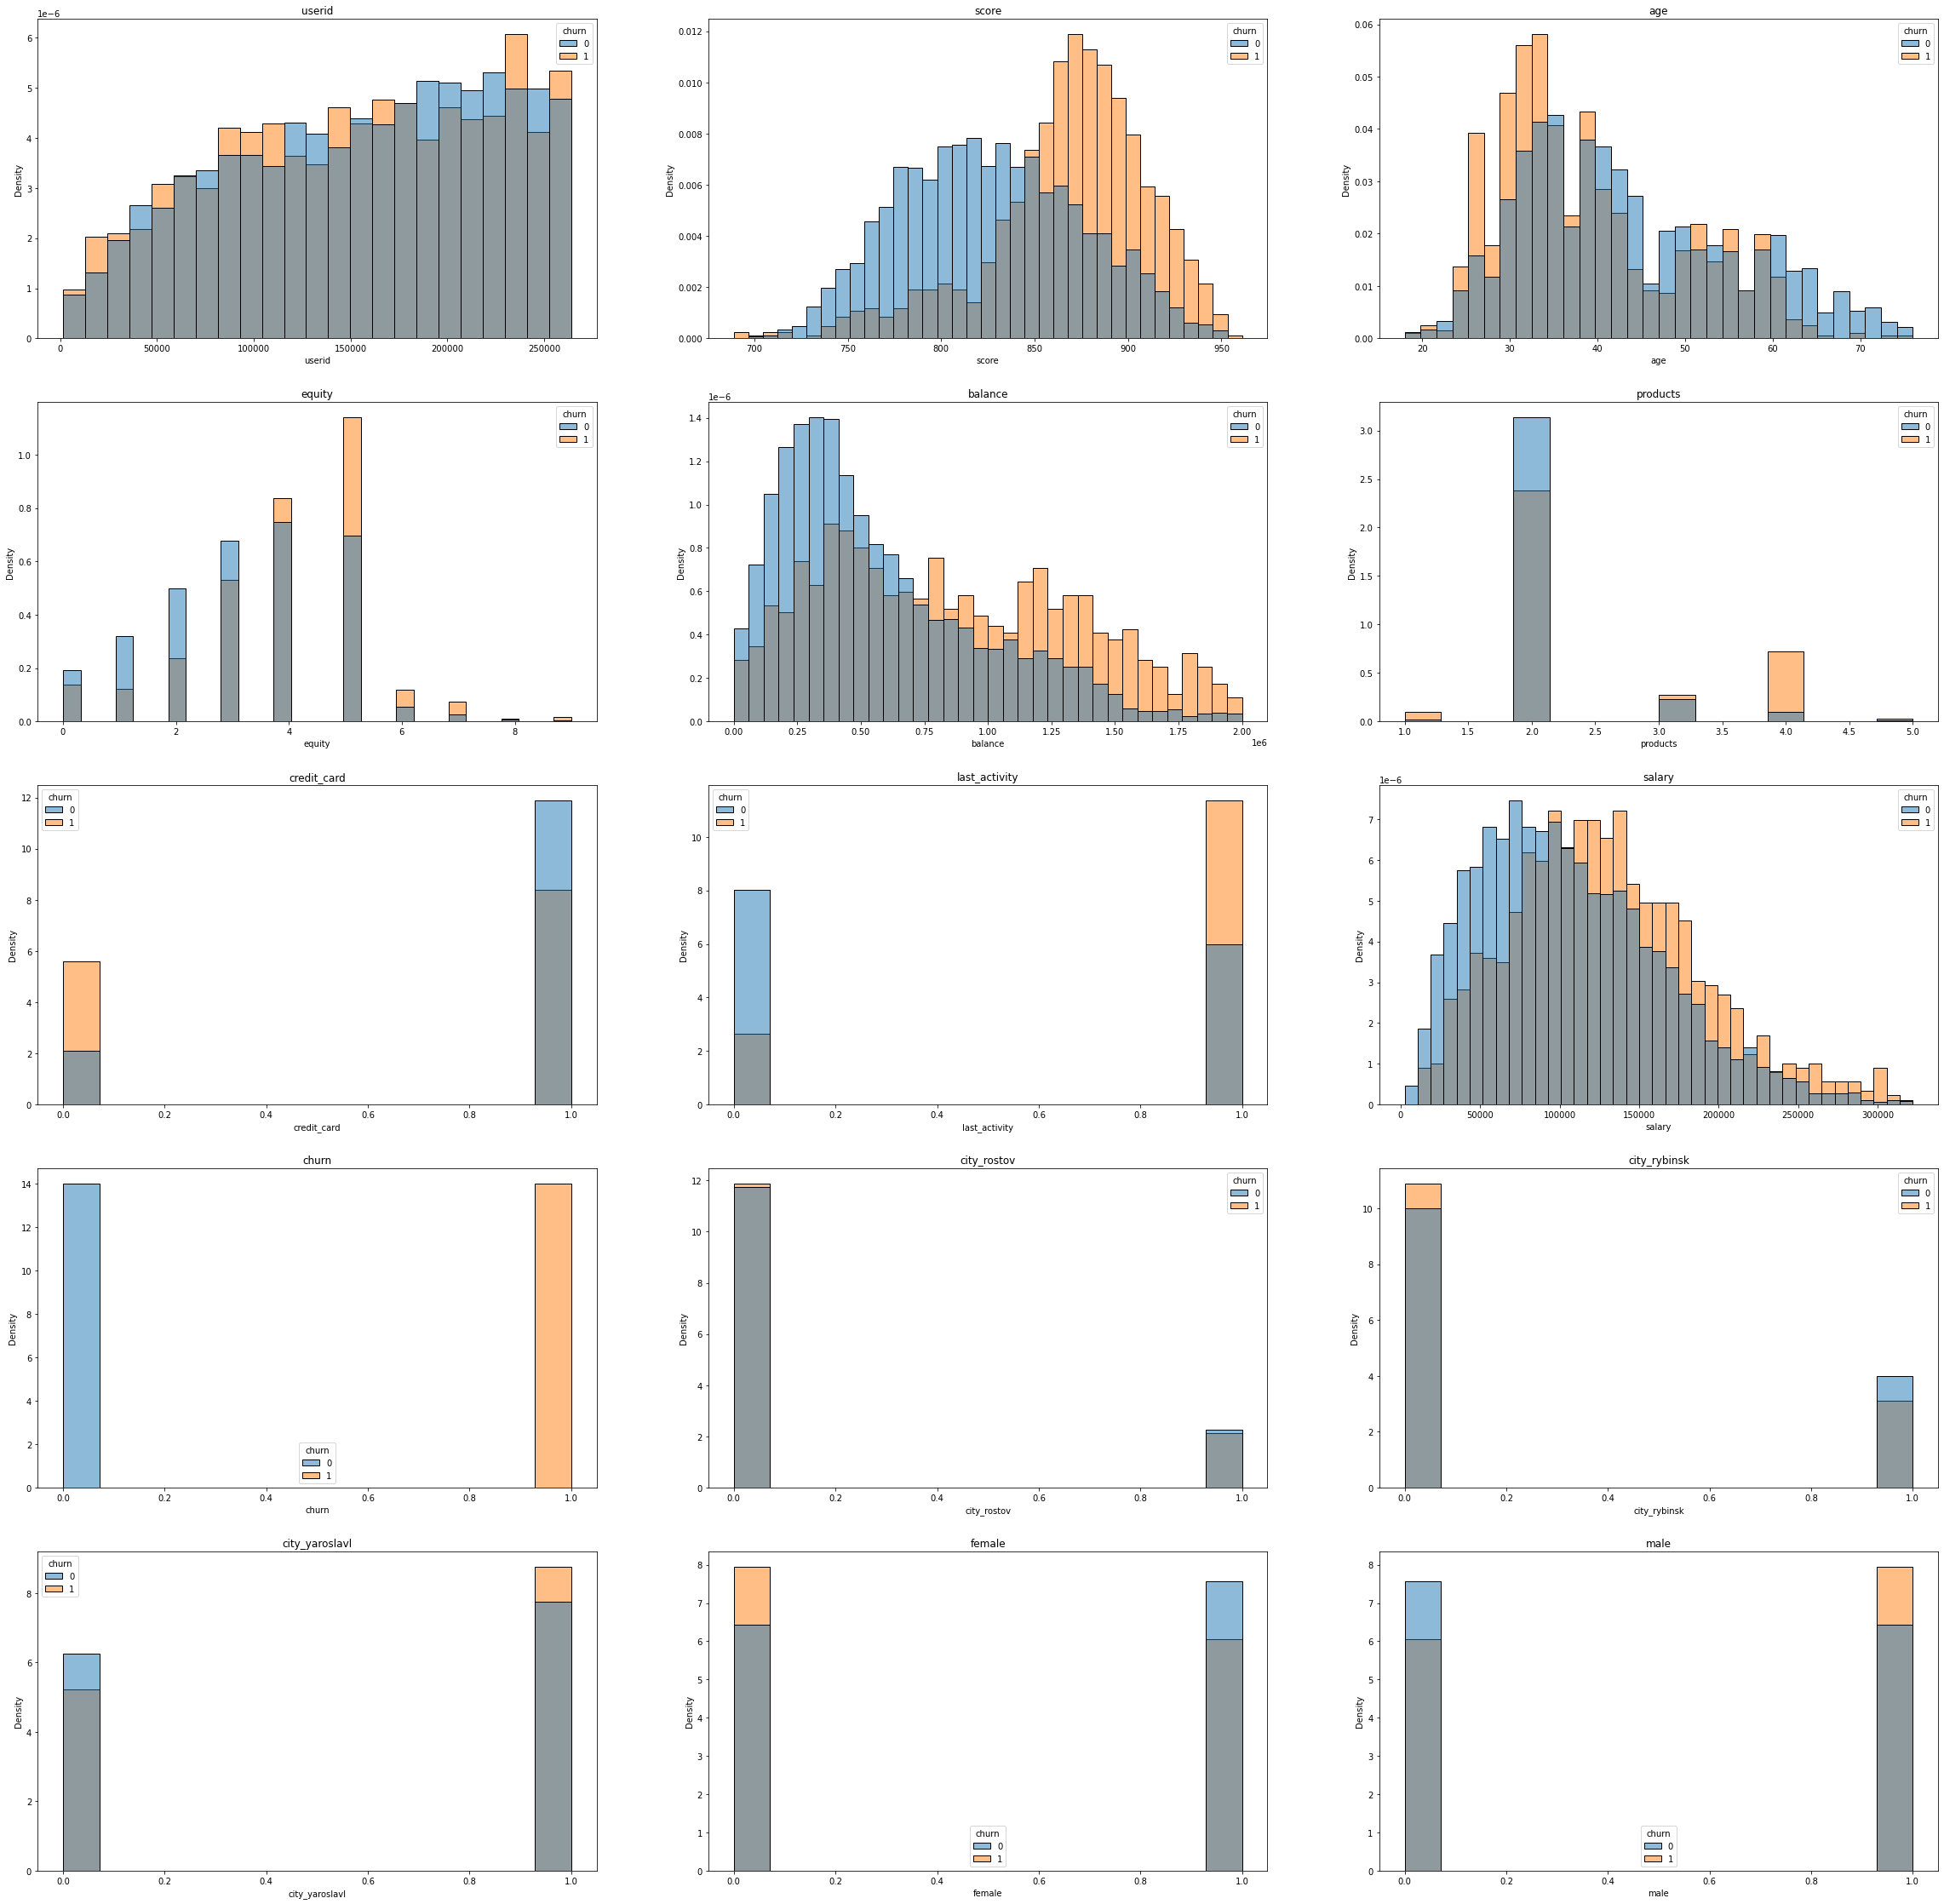

In [25]:
#Построим гистограммы
fig, axis = plt.subplots(5, 3,figsize=[40,40])
axis = axis.flatten()
for num, col in enumerate(final_df):                                                                               
    sns.histplot (data = final_df, x = col, ax = axis[num], stat="density", common_norm=False, hue='churn') 
    axis[num].set_title(f'{col}')  

* По показателю score видно, что к оттоку склонны клиенты с высокими баллами кредитного скоринга (от 850 до 950 баллов). Можно предположить, что это связано с неудвлетворенностью клиентов работой банка (не устраивают предлагаемые банковские продукты, условия).
* По показателю age заметно, что среди возрастной категории 25-35 лет большая часть клиентов склонна к оттоку. Здесь можно предположить, что молодые люди предьявляют более высокие требования к банковским услугам. Например,  молодые люди более активно пользуются современными диджитал-инструментами для управления финансами.  
* По показателю equity видно, что больше склонны к оттоку клиенты с высоким показателем оценки собственности (от 4 и выше). Можно предположить, что это состоятельные клиенты,которым нужен премиальный сервис.Банк не обеспечивает их нужд.
* К оттоку также подвержены клиенты с различным балансом , ЗП.
* Оптимальное количество продуктов - 2 (с таким количеством больше всего оставшихся клиентов). Также видно, что  клиенты, владеющие большим количеством продуктов (3-4) больше склонны к оттоку.
* Судя по показателю credit_ card, к оттоку склонна большая часть клиентов не имеющих кредитных  карт. Это логично, так как данные клиенты не привязаны к банку, у них нет кредитов, они могут выбирать любой банк.
* Судя по показателю last_activity, к оттоку склонна большая часть клиентов, которые были активны в последнее время.
* Больше всего подвержены к оттоку клиенты из Ярославля. Возможно, филиалы банка в данном городе работают хуже, меньше проводится акций, рекламных компаний.
* Чаще подвержены оттоку мужчины.

#### 3.3 Построим матрицу корреляций

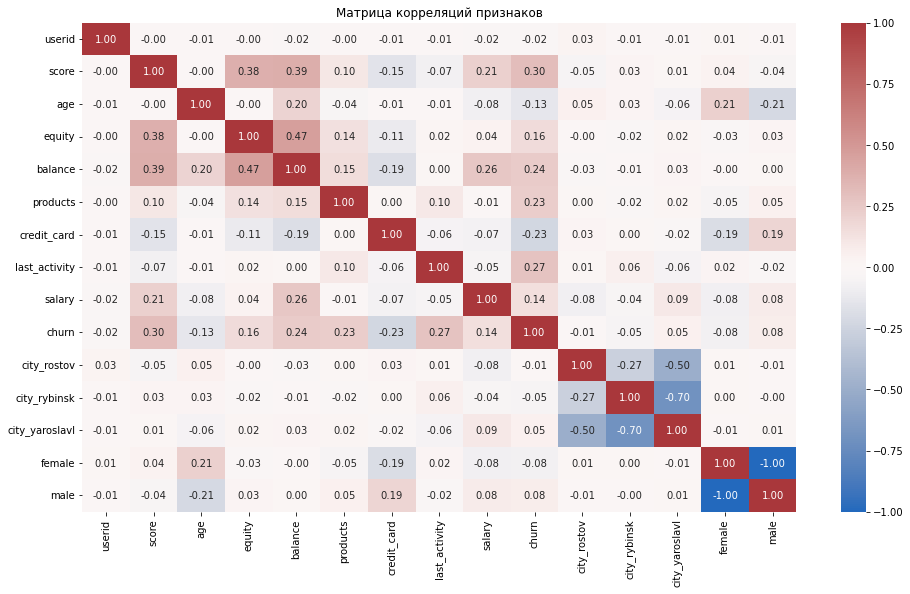

In [26]:
#Рассчитываем матрицу
corr_matrix = final_df.query('balance > 0').corr()

#Cтроим тепловую карту
plt.figure(figsize=(16, 9))
plt.title('Матрица корреляций признаков')
ax=sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='vlag'
)
plt.show()

Как видно из матрицы:

* наибольшие коэффициенты корреляции с целевой переменной churn (>0,25) у признаков last_activity (0,27) и score(0,3). Отток связан с баллами кредитного скоринга клиентов  и их активностью. Чем чаще клиент взаимодействует с банком, тем он требовательнее к банковским продуктам, услугам. Наиболее платежеспособные клиенты, также, скорее всего, предъявляют более высокие требования к качеству банковских услуг. Соответственно, связь данных признаков с целевой переменной понятна. 


* от 0,2 до 0,25 у целевой переменной корреляция с признаками balance(0,24), credit_card(-0,23) и products(0,23). По признаку balance связь с целевой переменной можно объяснить также неудвлетворенностью работой банка. Чем выше баланс, тем требовательнее клиент. Как мы выяснили в п.3.2, к оттоку склонна большая часть клиентов не имеющих кредитных  карт. Этим объясняется связь данного признака с целевой переменной. Клиенты без кредитов могут свободно выбирать любой банк. Также, целевая переменная связана с количеством банковских продуктов. Чем большим количеством продуктов пользуется клиентов, тем он чаще взаимодействует с банком и тем он требовательнее к банковским продуктам, услугам.


* от 0,1 до 0,2 у целевой переменной корреляция с признаками salary(0,14), equity(0,16) и age(-0,13). По данным показателям связь также можно объяснить более высокими требованиями к обслуживанию у людей с высокой ЗП, высокими показателями оценки собственности. И как мы выяснили в п.3.2, к оотоку больше подвержены молодые люди (25-35 лет).

### Шаг 4.Сформулируем и проверим статистические гипотезы. 

В пункте 3.3 мы определили, что у нас имеется 2 признака, имеющих наиболее сильную корреляцию с целевой переменной. С учётом того, что  также поставлена задача проверить гипотезу о различии доходов между теми клиентами, которые ушли и теми, которые остались, всего нужно проверить 3 гипотезы:

* гипотезу о различии доходов;
* гипотезу о различии last_activity;
* гипотезу о различии score.

In [27]:
#Выборки
df_churn_0 = final_df[final_df['churn'] == 0] # не планируют уходить
df_churn_1 = final_df[final_df['churn'] == 1] # планируют уходить

In [28]:
#Проверим размеры выборок
print('Размеры выборок составляют: для попавших в отток - {}, для оставшихся в банке - {}'.format(
        len(df_churn_1),
        len(df_churn_0)))

Размеры выборок составляют: для попавших в отток - 1083, для оставшихся в банке - 6101


Размеры выборок значительно отличаются. Будем использовать для проверки непараметрический критерий Манна-Уитни. Уровень статистической значимости принимаем равным 0,05.

С учётом того, что нам предстоит множественная проверка гипотез, необходимо скомпенсировать накопление ошибки первого рода. Применим поправку Бонферрони - разделим выбранный уровень значимости на количество проводимых тестов.

#### 4.1 Гипотеза о различии доходов у клиентов в оттоке / не в оттоке

Сформулируем гипотезу:

H0: среднее значение дохода клиентов, ушедших в отток равно среднему значению дохода клиентов, оставшихся с банком

H1: среднее значение дохода клиентов, ушедших в отток отличается от среднего значению дохода клиентов, оставшихся с банком

Для проверки стат. гипотезы будем использовать критерий Манна-Уитни. Это непараметрический критерий для сравнения двух независимых групп, который для проверки статистических гипотез не использует предположений о распределении генеральной совокупности. Не будем использовать t-критерий Стьюдента, так как для него необходимо, чтобы данные имели нормальное распределение.  

Параметр alternative='two-sided' в методе stats.mannwhitneyu  означает двусторонний тест, сравнение выборок производится "в обе стороны".

In [29]:
#Формируем выборки
sample_A = final_df.query('churn == 0')['salary']
sample_B = final_df.query('churn == 1')['salary']

In [30]:
#Задаём уровень критерия статистической значимости
alpha = 0.05

#Количество тестов
n_test = 3

#Рассчитываем итоговый уровень критерия статистической значимости с учётом поправки Бонферрони
alpha_corr = alpha / n_test

#Проводим тест
result = stats.mannwhitneyu(sample_A, sample_B)

#Получаем значение p-value
p_value = result.pvalue

#Сравниваем полученное значение с критерием
if p_value > alpha_corr:
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print('Отвергаем нулевую гипотезу')

Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута, т.е. есть статистически значимые различий между средними двух выборок. Посмотрим на относительную разницу средних:

In [31]:
print('{0:.2%}'.format(sample_B.mean() / sample_A.mean() - 1))

21.79%


Полученное значение подтверждает выводы теста, относительная разница средних высокая.

#### 4.2 Гипотеза о различии last_activity

Сформулируем гипотезу:

H0: доля неактивных клиентов, ушедших в отток (last_activity = 0) равна доле активных клиентов (last_activity = 1), ушедших в отток

H1: доля неактивных клиентов, ушедших в отток (last_activity = 0) не равна доле активных клиентов (last_activity = 1), ушедших в отток

In [32]:
#Формируем выборки
# с количеством клиентов со значениям признака last_activity 0 и 1
sample_A = list(final_df.groupby('last_activity').agg({'userid':'count'})['userid'])
# с количеством клиентов, ушедших в отток, со значениям признака last_activity 0 и 1
sample_B = list(final_df.query('churn == 1').groupby('last_activity').agg({'userid':'count'})['userid'])

In [33]:
#Проверка равенства долей
def z_test(before, after):
    successes = np.array(after)
    trials = np.array(before)
     
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2

    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    distr = stats.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    return p_value


#Получаем значение p-value
p_value = z_test(
    sample_A,
    sample_B
)

#Сравниваем полученное значение с критерием
if p_value > alpha_corr:
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print('Отвергаем нулевую гипотезу')

Отвергаем нулевую гипотезу


Нулевую гипотеза отвергнута, т.е. между средними значениями имеются статистически значимые различия. Посмотрим на относительную разницу средних:

In [34]:
print('{0:.2%}'.format(sample_B[0] / sample_A[0] *  sample_A[1] / sample_B[1] - 1))

-78.11%


Разница средних существенна.

#### 4.3 Гипотеза о различии score

Сформулируем гипотезу:

H0: среднее значение баллов кредитного рейтинга, ушедших в отток равно среднему значению баллов кредитного рейтинга, оставшихся с банком.

H1: среднее значение баллов кредитного рейтинга, ушедших в отток отличается от среднего значению баллов кредитного рейтинга, оставшихся с банком.

In [35]:
#Формируем выборки
sample_A = final_df.query('churn == 0')['score']
sample_B = final_df.query('churn == 1')['score']

#Задаём уровень критерия статистической значимости
alpha = 0.05

#Количество тестов
n_test = 3

#Рассчитываем итоговый уровень критерия статистической значимости с учётом поправки Бонферрони
alpha_corr = alpha / n_test

#Проводим тест
result = stats.mannwhitneyu(sample_A, sample_B)

#Получаем значение p-value
p_value = result.pvalue

#Сравниваем полученное значение с критерием
if p_value > alpha_corr:
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print('Отвергаем нулевую гипотезу')

Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута, т.е. есть статистически значимые различий между средними двух выборок. Посмотрим на относительную разницу средних:

In [36]:
print('{0:.2%}'.format(sample_B.mean() / sample_A.mean() - 1))

5.14%


Относительная разница есть.

### Шаг 5. Сегментация

Изучим средние и медианы по подготовленным данным в разрезе оттока.

In [37]:
#Средние значения
final_df.drop(['userid'], axis=1).groupby('churn').mean()

,score,age,equity,balance,products,credit_card,last_activity,salary,city_rostov,city_rybinsk,city_yaroslavl,female,male
churn,,,,,,,,,,,,,
0,825.942141,43.544829,3.231929,568775.367984,2.126045,0.849041,0.427471,106065.124153,0.161449,0.285035,0.553516,0.541059,0.458941
1,868.362881,39.007387,3.939982,857260.519187,2.484765,0.600185,0.811634,129176.605152,0.151431,0.222530,0.626039,0.432133,0.567867


In [38]:
#Медианные значения
final_df.drop(['userid'], axis=1).groupby('churn').median()

,score,age,equity,balance,products,credit_card,last_activity,salary,city_rostov,city_rybinsk,city_yaroslavl,female,male
churn,,,,,,,,,,,,,
0,824.0,41.0,3.0,456176.79,2.0,1.0,0.0,97888.70,0.0,0.0,1.0,1.0,0.0
1,873.0,36.0,4.0,793229.81,2.0,1.0,1.0,122983.06,0.0,0.0,1.0,0.0,1.0


На основе данных исследовательского анализа, анализа средних медиан построим портрет отточного и не отточного клиента

Портрет отточного клиента:
* Средний балл кредитного скоринга 868. 
* Средний возраст клиента 39 лет.
* Средняя оценка собственности 4 балла.
* Среднее значение баланса 857 тыс. рублей.
* В среднем клиент владеет 2 продуктами.
* У него есть кредитная карта.
* Клиент был активен в последнее время.
* Средняя ЗП равна 129176 руб.
* Клиент из Ярославля.
* Клиент мужчина.

Портрет не отточного клиента:
* Средний балл кредитного скоринга 826. 
* Средний возраст клиента 44 года.
* Средняя оценка собственности 3 балла.
* Среднее значение баланса 569 тыс. рублей.
* В среднем клиент владеет 2 продуктами.
* У него есть кредитная карта.
* Клиент не был активен в последнее время.
* Средняя ЗП равна 106 065 руб.
* Клиент из Ярославля.
* Клиент женщина.

На основе данных исследовательского анализа, анализа средних медиан, матрицы корреляций выделим стратегические признаки, влияющие на отток.

К стратегическим признакам, влияющим на отток относятся:
* Средний балл кредитного скоринга - видна разница в средних у отточных и не отточных клиентов(около 5%), самый высокий коэффициент корреляции (0,3). Кроме того, по результатам исследовательского анализа видно, что к оттоку склонны клиенты с высокими баллами кредитного скоринга (от 850 до 950 баллов). Проверка гипотезы подтвердила различия в выборках.    
* Активность - являтся различным у отточных и не отточных клиентов, высокий коэффициент корреляции (0,27). По результатам исследовательского анализа установлено, что к оттоку склонна большая часть клиентов, которые были активны в последнее время. Проверка гипотезы подтвердила различия в выборках. 
* Баланс - существенное различие средних балансов у отточных и не отточных клиентов, высокий коэффициент корреляции (0,24).
* ЗП - существенное различие средних ЗП у отточных и не отточных клиентов,  коэффициент корреляции (0,14). Проверка гипотезы подтвердила различия в выборках. 
* Также к стратегическим признакам отнесем пол - получили различия по портретам. По результатам исследовательского анализа видно, что чаще подвержены оттоку мужчины. 
* Возраст - получили различия по портретам. По результатам исследовательского анализа видно, что чаще подвержены оттоку молодые люди. 
    

Деление стратегически важных численных признаков на интервальные категории в соответствии с уровнем оттока. 

К численным стратегическим признакам относятся: средний балл кредитного скоринга, баланс, ЗП, возраст.

<AxesSubplot:xlabel='score', ylabel='Count'>

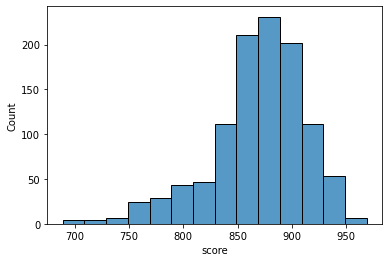

In [149]:
#Датасет
df_churn_1 = final_df[final_df['churn'] == 1]
#Cредний балл кредитного скоринга
sns.histplot(data =df_churn_1, x ="score", binwidth=20)

In [40]:
#Минимальное и макcимальное значение в score
min_score = df_churn_1['score'].min()
print(f"Минимальное значение в столбце score - {min_score}")
max_score = df_churn_1['score'].max()
print(f"Максимальное значение в столбце score - {max_score}")

Минимальное значение в столбце score - 689.0
Максимальное значение в столбце score - 961.0


Выделим интервальные категории, связанные с оттоком по баллам кредитного скоринга:
* Наибольший отток (count выше 100) наблюдается у группы клиентов с баллами кредитного скоринга 850-920.
* Средние значения оттока (count от 50 до 100) у группы клиентов с баллами кредитного скоринга 830-850 и 920-940.
* Наименьшие значения оттока (count до 50) у группы клиентов с баллами от 689 до 830 и от 940 до 961.

<AxesSubplot:xlabel='balance', ylabel='Count'>

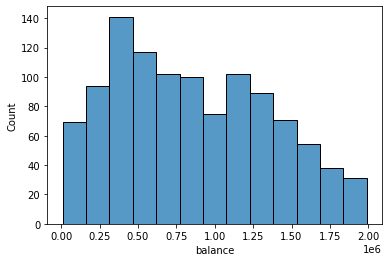

In [41]:
#Баланс
sns.histplot(data =df_churn_1, x ="balance")

In [43]:
#Минимальное и макимальное значение в balance
min_balance = df_churn_1['balance'].min()
print(f"Минимальное значение в столбце balance - {min_balance}")
max_balance = df_churn_1['balance'].max()
print(f"Максимальное значение в столбце balance - {max_balance}")

Минимальное значение в столбце balance - 8155.48
Максимальное значение в столбце balance - 1990994.07


Выделим интервальные категории, связанные с балансом:
* Наибольший отток (count выше 100) наблюдается у группы клиентов с балансом  250-600тыс.
* Средние значения оттока (count от 50 до 100) у группы клиентов с балансом 0-250тыс и 600-1,5млн.
* Наименьшие значения оттока (count до 50) у группы клиентов с балансом 1,5- 2млн.

<AxesSubplot:xlabel='salary', ylabel='Count'>

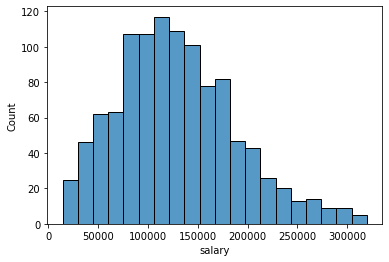

In [44]:
#ЗП
sns.histplot(data =df_churn_1, x ="salary")

In [47]:
#Минимальное и макимальное значение в salary
min_salary = df_churn_1['salary'].min()
print(f"Минимальное значение в столбце salary - {min_salary}")
max_salary = df_churn_1['salary'].max()
print(f"Максимальное значение в столбце balance - {max_salary}")

Минимальное значение в столбце salary - 14288.02
Максимальное значение в столбце balance - 319714.04


Выделим интервальные категории, связанные с ЗП:

* Наибольший отток (count выше 80) наблюдается у группы клиентов с ЗП 75-150тыс.
* Средние значения оттока (count от 30 до 80) у группы клиентов с ЗП 30-75тыс и 150-210тыс.
* Наименьшие значения оттока (count до 30) у группы клиентов с ЗП 14-30тыс. и 210 - 320тыс.

<AxesSubplot:xlabel='age', ylabel='Count'>

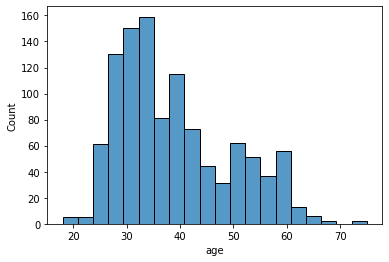

In [130]:
#Cредний возраст
sns.histplot(data =df_churn_1, x ="age")

In [132]:
#Минимальное и макимальное значение в age
min_age = df_churn_1['age'].min()
print(f"Минимальное значение в столбце age - {min_age}")
max_age = df_churn_1['age'].max()
print(f"Максимальное значение в столбце age - {max_age}")

Минимальное значение в столбце age - 18
Максимальное значение в столбце age - 75


Выделим интервальные категории, связанные с возрастом:

* Наибольший отток (count выше 75) наблюдается у группы клиентов 25-45 лет
* Средние значения оттока (count от 20 до 75) у группы клиентов 25-30 и 45-60.
* Меньше всего отток (count до 20) у группы клиентов 18-25 и 60-75.

In [194]:
#Среднее значение churn в финальном датасете
print(f"Среднее значение сhurn в финальном датасете {round(final_df['churn'].mean(),2)}")
print(f"Всего строк в финальном датасете {len(final_df)}") 

Среднее значение сhurn в финальном датасете 0.15
Всего строк в финальном датасете 7184


Путем множественного перебора стратегических признаков, выделим следующие сегменты, которые наиболее важны для банка (с высоким уровнем оттока)

1. Активные клиенты с высокими баллами скоринга:

In [281]:
#Выделим сегмент 
df_1_churn = final_df.loc[
(final_df['score'] < 920) & (final_df['score'] > 850)                         
& (final_df['last_activity'] == 1) 
]                          
print(f"Величига сегмента {len(df_1_churn)} строка")        
print(f"Среднее значение сhurn {round(df_1_churn['churn'].mean(),2)}")

Величига сегмента 1071 строка
Среднее значение сhurn 0.55


In [282]:
df_1_churn.describe()

,userid,score,age,equity,balance,products,credit_card,last_activity,salary,churn,city_rostov,city_rybinsk,city_yaroslavl,female,male
count,1071.000000,1071.000000,1071.000000,1071.000000,1.071000e+03,1071.000000,1071.000000,1071.0,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000,1071.000000
mean,155099.473389,878.944911,42.518207,4.068161,7.878730e+05,2.352007,0.677871,1.0,115207.725191,0.553688,0.129785,0.366947,0.503268,0.582633,0.417367
std,69324.566796,18.848777,13.662945,1.334665,4.431777e+05,0.769933,0.467510,0.0,58904.177699,0.497341,0.336224,0.482197,0.500223,0.493355,0.493355
min,3450.000000,851.000000,18.000000,0.000000,8.126880e+03,1.000000,0.000000,1.0,8587.790000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,100105.000000,863.000000,32.000000,3.000000,4.346189e+05,2.000000,0.000000,1.0,70923.265000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,160327.000000,877.000000,38.000000,4.000000,7.180664e+05,2.000000,1.000000,1.0,109597.890000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,216568.500000,894.000000,54.500000,5.000000,1.089883e+06,2.000000,1.000000,1.0,149291.635000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,263963.000000,919.000000,76.000000,9.000000,1.990371e+06,5.000000,1.000000,1.0,319714.040000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [270]:
#Средние значения по оттоку
df_1_churn.drop(['userid'], axis=1).groupby('churn').mean()

,score,age,equity,balance,products,credit_card,last_activity,salary,city_rostov,city_rybinsk,city_yaroslavl,female,male
churn,,,,,,,,,,,,,
0,876.169456,48.077406,3.987448,672386.334916,2.433054,0.843096,1.0,93255.917992,0.123431,0.504184,0.372385,0.719665,0.280335
1,881.182125,38.037099,4.133221,880963.379730,2.286678,0.544688,1.0,132902.436560,0.134907,0.256324,0.608769,0.472175,0.527825


По результатам сегментации получен сегмент с высоким средним значением оттока 0,55 (выше среднего более чем в з раза). В данном сегменте все пользователи бвли активны и имеют баллы кредитного скоринга от 850 до 920 баллов.

Среди отточных  преобладают мужчины из Ярославля с высокой средней ЗП 133 тыс. рублей, возрастом - 38 лет. У большинства есть кредитные карты.Клиенты позьзуются двумя продуктами. Средний балл оценки собственности - 4. Баланс около 880 тыс.

Исходя из особенностей данного сегмента (прежде всего активность, высокие баллы кредитного скоринга, а также довольно высокими значениями ЗП, оценки собственности) можно дать следующие рекомендации по уменьшению оттока:
* Так как данные клиенты являются ценными для банка (хорошие показатели ЗП, баланса и т.д) необходимо предлагать стимулы, такие как скидки и специальные предложения, тем клиентам, которые были идентифицированы как склонные к оттоку. Предложение стимулов и скидок широко рассматривается, как наиболее эффективная тактика сокращения оттока капитала. Так как можно сказать, что данные клиенты являются финансово устойчивыми, необходимо обратить внимание на такие банковские продукты как - инвестирование в акции, вложения в фонды.
* Так как все клиенты сегмента являются активными, то есть часто взаимодействуют с банком, необходимо персонализировать сервис, обеспечить более качественное обслуживание клиентов.
*  Так как большая часть отточных клиентов из Ярославля, необходимо увеличить количество рекламы, акций банка в городе (например предлагать вклады по более высоким процентам). Проверить работы местного менеджмента, возможно пплохое управление сказывается на работе филиалов в данном городе,  и как следствии приводит к неудвлетворенности клиентов.  

2. Сегмент сотоящий из мужчин возрастом 25-45 лет, активно пользующихся банком.

In [278]:
#Выделим еще один сегмент 
df_2_churn = final_df.loc[                  
(final_df['male'] == 1)
&(final_df['last_activity'] == 1)   
& (final_df['age'] < 45) & (final_df['age'] > 25)                      
]
print(f"Величига сегмента {len(df_2_churn)} строка")        
print(f"Среднее значение сhurn {round(df_2_churn['churn'].mean(),2)}")

Величига сегмента 1088 строка
Среднее значение сhurn 0.32


In [279]:
df_2_churn.describe()

,userid,score,age,equity,balance,products,credit_card,last_activity,salary,churn,city_rostov,city_rybinsk,city_yaroslavl,female,male
count,1088.000000,1088.000000,1088.000000,1088.000000,1.088000e+03,1088.000000,1088.000000,1088.0,1088.000000,1088.00000,1088.000000,1088.000000,1088.000000,1088.0,1088.0
mean,153982.750919,826.668199,34.755515,3.486213,6.120567e+05,2.307904,0.850184,1.0,117227.601875,0.32261,0.150735,0.304228,0.545037,0.0,1.0
std,68248.536947,50.505041,5.017262,1.594549,4.305108e+05,0.726583,0.357055,0.0,58416.670133,0.46769,0.357955,0.460291,0.498197,0.0,0.0
min,2229.000000,711.000000,26.000000,0.000000,1.467432e+04,1.000000,0.000000,1.0,9766.130000,0.00000,0.000000,0.000000,0.000000,0.0,1.0
25%,99781.750000,787.000000,31.000000,2.000000,2.644735e+05,2.000000,1.000000,1.0,73837.327500,0.00000,0.000000,0.000000,0.000000,0.0,1.0
50%,159493.000000,823.000000,35.000000,4.000000,4.902841e+05,2.000000,1.000000,1.0,110296.555000,0.00000,0.000000,0.000000,1.000000,0.0,1.0
75%,215573.250000,864.000000,39.000000,5.000000,8.808412e+05,2.000000,1.000000,1.0,152415.580000,1.00000,0.000000,1.000000,1.000000,0.0,1.0
max,263591.000000,952.000000,44.000000,9.000000,1.955521e+06,5.000000,1.000000,1.0,312656.560000,1.00000,1.000000,1.000000,1.000000,0.0,1.0


In [275]:
#Средние значения по оттоку
df_2_churn.drop(['userid'], axis=1).groupby('churn').mean()

,score,age,equity,balance,products,credit_card,last_activity,salary,city_rostov,city_rybinsk,city_yaroslavl,female,male
churn,,,,,,,,,,,,,
0,803.215739,35.426052,3.195387,502321.942619,2.246947,0.919946,1.0,108821.743813,0.153324,0.310719,0.535957,0.0,1.0
1,875.911681,33.347578,4.096866,842468.495128,2.435897,0.703704,1.0,134877.508974,0.145299,0.290598,0.564103,0.0,1.0


По результатам сегментации получен сегмент со  средним значением оттока 0,32 (больше среднего). В данном сегменте все пользователи бвли активны и имеют баллы кредитного скоринга от 850 до 920 баллов.

Среди отточных  преобладают мужчины из Ярославля с высокой средней ЗП 134 тыс. рублей, возрастом - 33 года. У большинства есть кредитные карты.Клиенты позьзуются двумя продуктами. Средний балл оценки собственности - 4. Баланс около 840 тыс.

Исходя из особенностей данного сегмента (прежде всего это пол и возраст) можно дать следующие рекомендации по уменьшению оттока:
* Так как данные клиенты являются мужчинами среднего возраста и активно пользуются банком нужно направить больше усилий на персональные предложения, разработать специальные банковские продукты для данной категории (например, проработать условия по автокредитам и более активно предлагать их клиентам данного сегмента).
* Также, так как данные клиенты часто пользуются банком, необходимо развивать интернет-банкинг, предлагать больше банковских цифровых продуктов для более качетсвенного и быстрого обслуживания.

### Выводы

По результатам сегментации получен сегмент с высоким средним значением оттока 0,55 (выше среднего более чем в з раза). В данном сегменте все пользователи бвли активны и имеют баллы кредитного скоринга от 850 до 920 баллов.

Среди отточных  преобладают мужчины из Ярославля с высокой средней ЗП 133 тыс. рублей, возрастом - 38 лет. У большинства есть кредитные карты. Клиенты позьзуются двумя продуктами. Средний балл оценки собственности - 4. Баланс около 880 тыс.

Исходя из особенностей данного сегмента (прежде всего активность, высокие баллы кредитного скоринга, а также довольно высокими значениями ЗП, оценки собственности) можно дать следующие рекомендации по уменьшению оттока:
* Так как данные клиенты являются ценными для банка (хорошие показатели ЗП, баланса и т.д) необходимо предлагать стимулы, такие как скидки и специальные предложения, тем клиентам, которые были идентифицированы как склонные к оттоку. Предложение стимулов и скидок широко рассматривается, как наиболее эффективная тактика сокращения оттока капитала. Так как можно сказать, что данные клиенты являются финансово устойчивыми, необходимо обратить внимание на такие банковские продукты как - инвестирование в акции, вложения в фонды.
* Так как все клиенты сегмента являются активными, то есть часто взаимодействуют с банком, необходимо персонализировать сервис, обеспечить более качественное обслуживание клиентов.
*  Так как большая часть отточных клиентов из Ярославля, необходимо увеличить количество рекламы, акций банка в городе. Проверить работы местного менеджмента, возможно пплохое управление сказывается на работе филиалов в данном городе,  и как следствии приводит к неудвлетворенности клиентов. 